In [ ]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor as rf_sk
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
import pyspark
from pyspark.ml.regression import RandomForestRegressor as rf_sp
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

In [ ]:
%cd D:\PDA_RAR_sqlite\data

D:\PDA_RAR_sqlite\data


In [ ]:
path = 'D:\\PDA_RAR_sqlite\\data'
full_path_list = [ path + '/' + f for \
                 f in os.listdir(path) if os.path.isfile(os.path.join(path,f)) ]

In [ ]:
# The fitbit dataset is inclusive of hours and minutes datasets as well. However, for the purpose of this exercise,
# it is chosen to analyze daily aggregated data only.

# connect to sql db
con = sql.connect("fitbit.db")
cur = con.cursor()

def get_table_name(full_path_list, i):
    return full_path_list[i].split("/")[-1].split('.')[0]

pbar = tqdm(total=len(full_path_list), desc='[Loading Data...]')
for i in range(0,len(full_path_list)):
    pd.read_csv(full_path_list[i]).to_sql(get_table_name(full_path_list, i), con, if_exists='append', index=False)
    pbar.update(1)
pbar.close()

[Loading Data...]: 100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.72it/s]


In [ ]:
# simple sql query test
df = pd.read_sql(f'SELECT * FROM {get_table_name(full_path_list, 0)}', con)
df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [ ]:
# list all tables
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
print(f'Total of {len(tables)} tables in database.')

Total of 8 tables in database.


In [ ]:
# check for sample data and data size
fitbit_df = pd.read_sql(f'SELECT * FROM fitbit_df', con)

print(len(fitbit_df))

fitbit_df.head()

413


,SedentaryMinutes,TotalSteps,TotalMinutesAsleep,TotalTimeInBed,Calories
0,728,13162,327,346,1985
1,776,10735,384,407,1797
2,726,9762,412,442,1745
3,773,12669,340,367,1863
4,539,9705,700,712,1728


In [ ]:
#1) perform exploratory analysis
# Average Calories, Steps and Distance by Id and by day of the week
query = """
SELECT
	ROUND(AVG(Calories),2) AS avg_calories,
	ROUND(AVG(TotalSteps),2) AS avg_steps,
	ROUND(AVG(TotalMinutesAsleep),2) AS avg_minutesAsleep
FROM fitbit_df
GROUP BY TotalTimeInBed;
"""

activity_dist = pd.read_sql(query, con)
activity_dist.head()

,avg_calories,avg_steps,avg_minutesAsleep
0,2225.0,5600.0,58.0
1,2402.5,6960.0,60.5
2,1804.0,5079.0,61.0
3,3331.0,19769.0,74.0
4,3051.0,1982.0,77.0


In [ ]:
# join fitbit data and sleep data
join_query = """
SELECT
	A.SedentaryMinutes,
	S.TotalMinutesAsleep
FROM
	fitbit_df A
INNER JOIN sleepDay_merged S
ON
    A.TotalTimeInBed=S.TotalTimeInBed;
"""
activity_sleep_df = pd.read_sql(join_query, con)

activity_sleep_df.head()

,SedentaryMinutes,TotalMinutesAsleep
0,728,319
1,728,327
2,776,384
3,776,388
4,776,391


<Axes: xlabel='TotalTimeInBed', ylabel='Calories'>

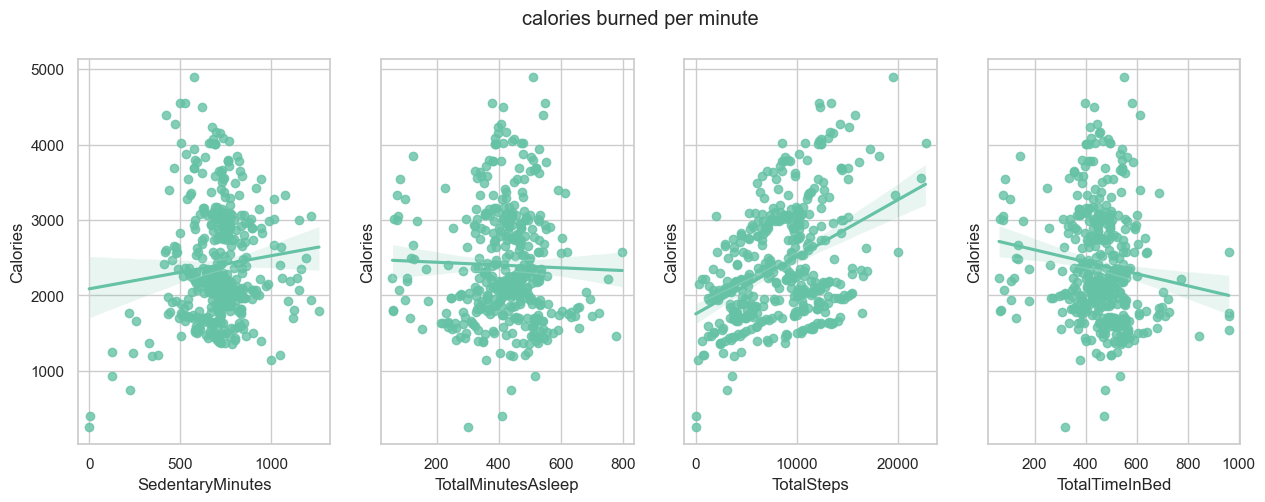

In [ ]:
#a) Initial Exploratory Visualizations
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('calories burned per minute')

sns.regplot(data = fitbit_df, x = 'SedentaryMinutes', y = 'Calories', ax=axes[0])

sns.regplot(data = fitbit_df, x = 'TotalMinutesAsleep', y = 'Calories', ax=axes[1])

sns.regplot(data = fitbit_df, x = 'TotalSteps', y = 'Calories', ax=axes[2])

sns.regplot(data = fitbit_df, x = 'TotalTimeInBed', y = 'Calories', ax=axes[3])

Index(['SedentaryMinutes', 'TotalSteps', 'TotalMinutesAsleep',
       'TotalTimeInBed', 'Calories'],
      dtype='object')


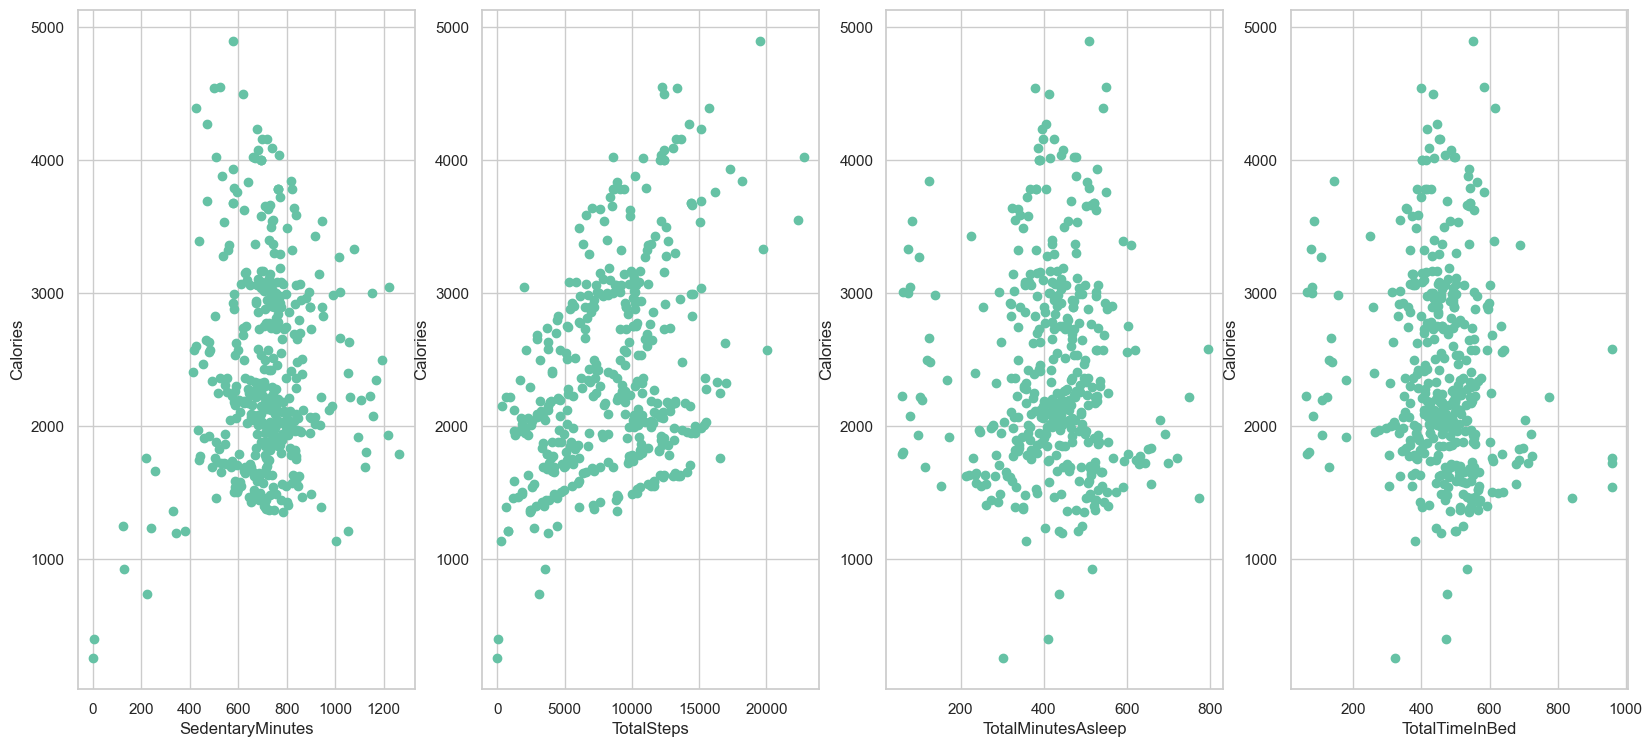

In [ ]:
#correlation measures
column_to_move = fitbit_df.pop("Calories")
fitbit_df.insert(4, "Calories", column_to_move)
print(fitbit_df.columns)

# Define a function to plot the scatterplots of the relationships between
# all independent variables and the dependent variable
def plot_relationships(df, num_cols):
    variables = df.columns

    # assume that the dependent variable is in the last column
    dep_var = variables[-1]
    ind_var = variables[:-1]
    figs = len(dep_var)
    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    fig = 1
    plt.figure(figsize=(20,30))
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

plot_relationships(fitbit_df,4)

<Axes: >

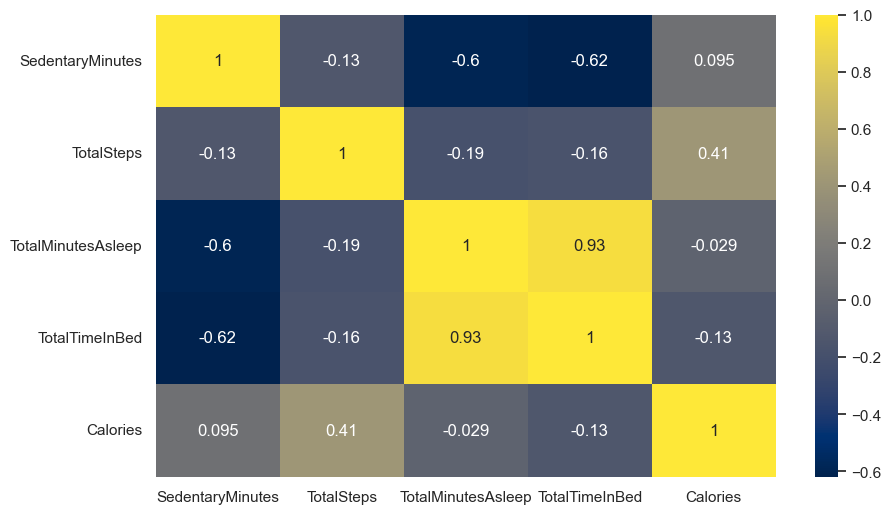

In [ ]:
# Plot the correlations as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(fitbit_df.corr(), annot=True, cmap='cividis', fmt='.2g')

In [ ]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(fitbit_df.iloc[:,:-1],
                                                              fitbit_df['Calories'],
                                                              test_size=0.2,
                                                              random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp,
                                                      test_size=0.25, random_state=42)

In [ ]:
# scale the data with object range of 0-1
scaler = MinMaxScaler()

scaler.fit_transform(X_train)

scaler.transform(X_valid)
scaler.transform(X_test)

array([[0.63330599, 0.36764383, 0.40785908, 0.37555556],
       [0.59557014, 0.45576408, 0.57859079, 0.48777778],
       [0.6997539 , 0.0528282 , 0.5799458 , 0.49111111],
       [0.56193601, 0.54379642, 0.44715447, 0.38444444],
       [0.90730107, 0.20476421, 0.06504065, 0.05222222],
       [0.61443806, 0.31455193, 0.38617886, 0.33222222],
       [0.39294504, 0.42082363, 0.73441734, 0.63888889],
       [0.59639048, 0.49997802, 0.49186992, 0.44      ],
       [0.54060705, 0.47061926, 0.49728997, 0.41555556],
       [0.6923708 , 0.60326111, 0.09214092, 0.08444444],
       [0.3388023 , 0.35990858, 0.57181572, 0.53888889],
       [0.5561936 , 0.36171054, 0.59891599, 0.55111111],
       [0.62674323, 0.23829825, 0.47425474, 0.43222222],
       [0.58736669, 0.30769569, 0.61382114, 0.53555556],
       [0.47087777, 0.40047466, 0.63821138, 0.55222222],
       [0.73420837, 0.08996616, 0.44715447, 0.40333333],
       [0.43478261, 0.28774228, 0.6504065 , 0.55444444],
       [0.47497949, 0.8581286 ,

In [ ]:
def scoring(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}.'.format(mae))
    print('Mean Squared Error: {:0.4f}.'.format(mse))
    print('R^2 Score = {:0.4f}.'.format(r2))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

# Create list of median predictions that has the same length as y_valid
baseline_y = [y_train.median()] * len(y_valid)

# Compute the relevant scores
base_predictions = baseline_y
base_mae = mean_absolute_error(y_valid, base_predictions)
base_mse = mean_squared_error(y_valid, base_predictions)
base_r2 = r2_score(y_valid, base_predictions)
base_errors = abs(base_predictions - y_valid)
base_mape = 100 * np.mean(base_errors / y_valid)
base_accuracy = 100 - base_mape
print('Model Performance')
print('Mean Absolute Error: {:0.4f}.'.format(base_mae))
print('Mean Squared Error: {:0.4f}.'.format(base_mse))
print('R^2 Score = {:0.4f}.'.format(base_r2))
print('Accuracy = {:0.2f}%.'.format(base_accuracy))

Model Performance
Mean Absolute Error: 649.0120.
Mean Squared Error: 650005.8072.
R^2 Score = -0.0292.
Accuracy = 72.74%.


In [ ]:
#We want to establish baseline scores based on the performance of a model which predicts the mean everytime. The baseline is useful to assess whether the models we are going to train are actually 'learning' anything from the data

Text(0, 0.5, 'Coefficients')

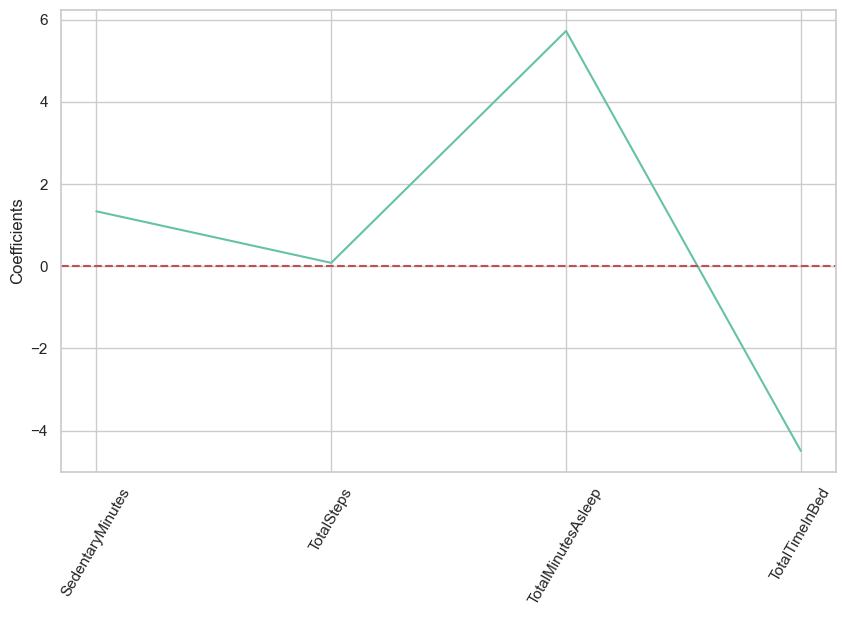

In [ ]:
# feature selection with lasso Regression
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

plt.figure(figsize=(10, 6))
plt.plot(range(len(X_train.columns)), lasso_coef)
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=60)
plt.axhline(0.0, linestyle='--', color='r')
plt.ylabel('Coefficients')

In [ ]:
#b) tree machine learning models RandomForest classifier
rf_regressor = rf_sk(random_state=42)
rf = rf_regressor.fit(X_train, y_train)

scoring(rf, X_valid, y_valid)

Model Performance
Mean Absolute Error: 506.9816.
Mean Squared Error: 407747.2590.
R^2 Score = 0.3544.
Accuracy = 77.49%.


In [ ]:
# decision tree classifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt_classifier=DecisionTreeClassifier()

In [ ]:
model=dt_classifier.fit(X_train,y_train)

In [ ]:
scoring(model,X_valid,y_valid)

Model Performance
Mean Absolute Error: 675.3494.
Mean Squared Error: 833114.9398.
R^2 Score = -0.3191.
Accuracy = 69.59%.


In [ ]:
#on comparing the two tree models random forest and DecisionTree Classifier the random forest model performs better with 77.49 % accuracy with high R^2 value

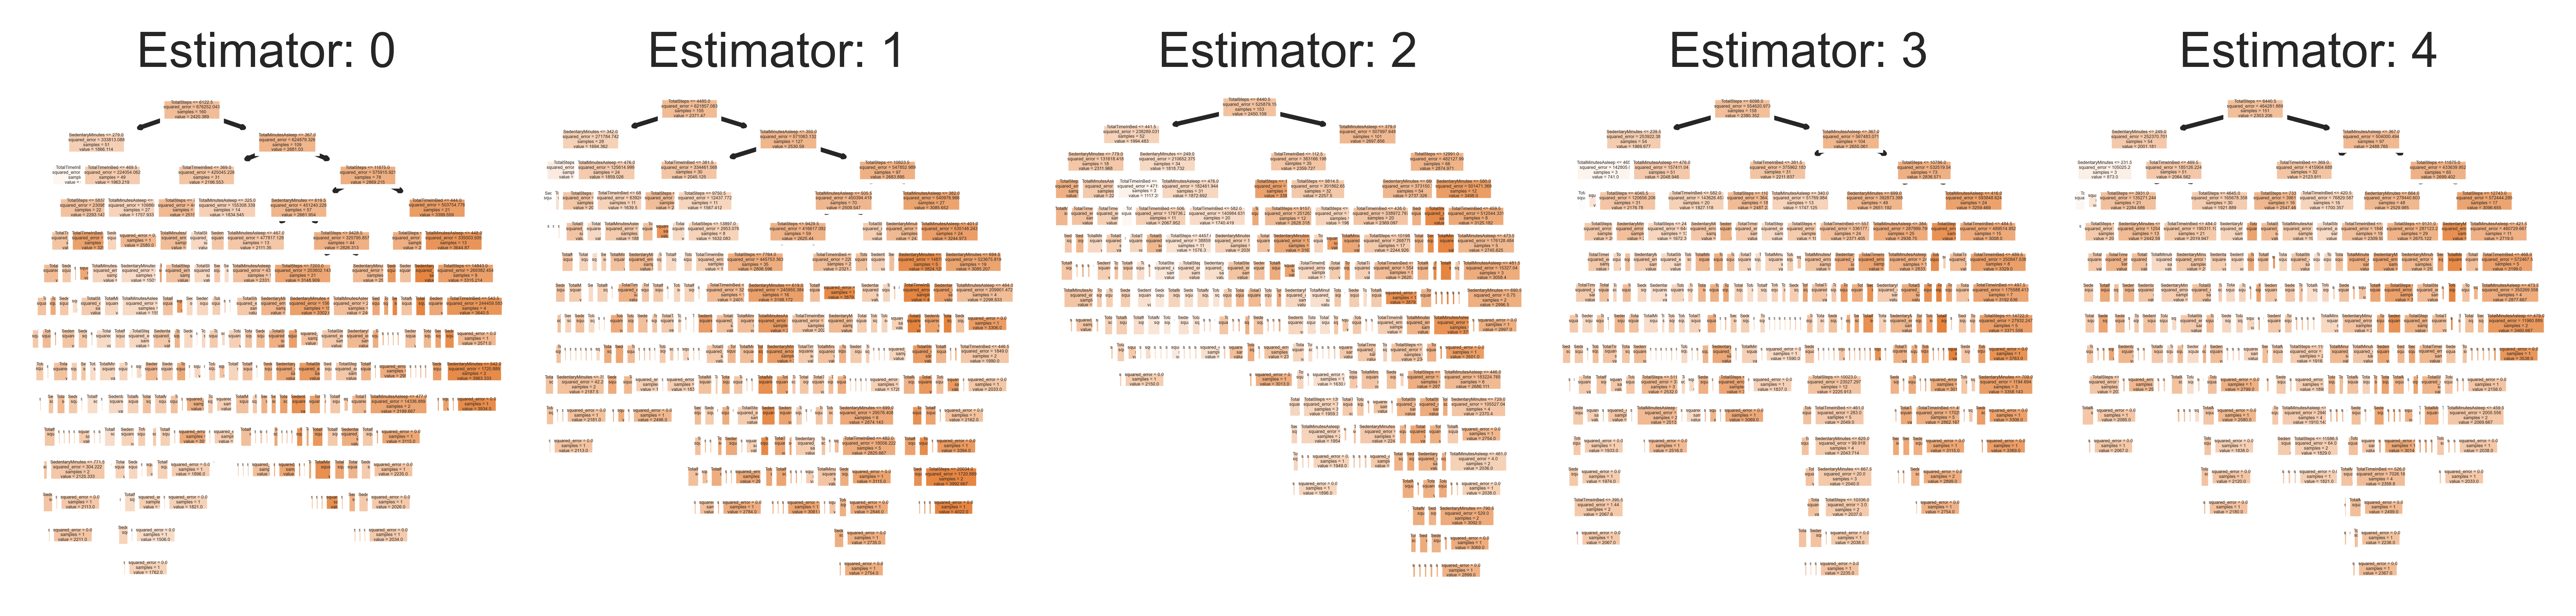

In [ ]:
# let's take a look at the first 5 estimators in the Random Forest
fn=['SedentaryMinutes', 'TotalSteps', 'TotalMinutesAsleep',
       'TotalTimeInBed']
cn=['Calories']
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(rf.estimators_[index],
                   feature_names = fn,
                   class_names=cn,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)

In [ ]:
#c)Choose the best performing model from Q.2b to implement a scalable workflow
using PySpark and report your observations.
fitbit_df.to_csv('fitbit_df.csv', index=False)

CSV_PATH = "./fitbit_df.csv"
APP_NAME = "Random Forest"
SPARK_URL = "local[*]"
RANDOM_SEED = 13579
TRAINING_DATA_RATIO = 0.7
RF_NUM_TREES = 3
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

spark = SparkSession.builder \
    .appName(APP_NAME) \
    .master(SPARK_URL) \
    .getOrCreate()

df = spark.read \
    .options(header = "true", inferschema = "true") \
    .csv(CSV_PATH)

print("Total number of rows: %d" % df.count())

df.printSchema()

df.show()

Total number of rows: 413
root
 |-- SedentaryMinutes: integer (nullable = true)
 |-- TotalSteps: integer (nullable = true)
 |-- TotalMinutesAsleep: integer (nullable = true)
 |-- TotalTimeInBed: integer (nullable = true)
 |-- Calories: integer (nullable = true)

+----------------+----------+------------------+--------------+--------+
|SedentaryMinutes|TotalSteps|TotalMinutesAsleep|TotalTimeInBed|Calories|
+----------------+----------+------------------+--------------+--------+
|             728|     13162|               327|           346|    1985|
|             776|     10735|               384|           407|    1797|
|             726|      9762|               412|           442|    1745|
|             773|     12669|               340|           367|    1863|
|             539|      9705|               700|           712|    1728|
|             775|     15506|               304|           320|    2035|
|             818|     10544|               360|           377|    1786|
|      

In [ ]:
# create features
featureCols = ['SedentaryMinutes', 'TotalSteps', 'TotalMinutesAsleep',
       'TotalTimeInBed']
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
df = assembler.transform(df)
spark_df = df.select(['features', 'Calories'])

spark_df.show()
spark_df.printSchema()

+--------------------+--------+
|            features|Calories|
+--------------------+--------+
|[728.0,13162.0,32...|    1985|
|[776.0,10735.0,38...|    1797|
|[726.0,9762.0,412...|    1745|
|[773.0,12669.0,34...|    1863|
|[539.0,9705.0,700...|    1728|
|[775.0,15506.0,30...|    2035|
|[818.0,10544.0,36...|    1786|
|[838.0,9819.0,325...|    1775|
|[732.0,14371.0,36...|    1949|
|[709.0,10039.0,43...|    1788|
|[814.0,15355.0,27...|    2013|
|[833.0,13755.0,24...|    1970|
|[782.0,13154.0,36...|    1898|
|[815.0,11181.0,34...|    1837|
|[712.0,14673.0,40...|    1947|
|[730.0,10602.0,36...|    1820|
|[798.0,14727.0,27...|    2004|
|[816.0,15103.0,27...|    1990|
|[857.0,14070.0,24...|    1959|
|[754.0,12159.0,33...|    1896|
+--------------------+--------+
only showing top 20 rows

root
 |-- features: vector (nullable = true)
 |-- Calories: integer (nullable = true)



In [ ]:
train, test = spark_df.randomSplit([0.8, 0.2], seed = 42)
print("Number of training set rows: %d" % train.count())
print("Number of test set rows: %d" % test.count())

Number of training set rows: 354
Number of test set rows: 59


In [ ]:
rf = rf_sp(featuresCol="features", labelCol='Calories')

model = rf.fit(train)

predictions = model.transform(test)

predictions.select("prediction", "Calories", "features").show(5)

preds = predictions.select('prediction').toPandas()['prediction']
test_labels = predictions.select('Calories').toPandas()['Calories']

errors = abs(preds - test_labels)
mape = 100 * np.mean(errors / test_labels)
accuracy = round(100 - mape, 4)
print(f'Accuracy = {accuracy} %')

+------------------+--------+--------------------+
|        prediction|Calories|            features|
+------------------+--------+--------------------+
|           1733.35|    1248|[125.0,4477.0,492...|
|1087.5881990231992|    1240|[241.0,2752.0,404...|
|2482.0934914487307|    1364|[330.0,8891.0,456...|
| 2467.814564470267|    2606|[425.0,11135.0,46...|
| 2465.741686834783|    2469|[456.0,7336.0,498...|
+------------------+--------+--------------------+
only showing top 5 rows

Accuracy = 76.2172 %


In [ ]:
#by using the pyspark for random forest we get accuracy of 76.2172%

In [ ]:
#d)Predict the calories using linear machine learning models and report the results.
regressor = LinearRegression()
mlr = regressor.fit(X_train, y_train)

scoring(mlr, X_valid, y_valid)

Model Performance
Mean Absolute Error: 571.5923.
Mean Squared Error: 461353.1211.
R^2 Score = 0.2695.
Accuracy = 74.79%.


# 2#A data scientist has to build an Artificial Neural Network (ANN) model consisting of
two hidden layers with activation function Rectifier Unit and sigmoid function at the
output layer for the dataset shown in Table.2. Design an ensemble workflow and Code
the steps involved in building an ANN using tensorflow with batch size 34 and 100
epochs. Also, predict if the customer with information shown in Table.2 will churn the
telecom service:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt


In [ ]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%cd D:\predictive_data_analysis\data

D:\predictive_data_analysis\data


In [ ]:
df=pd.read_csv("Telecom Customer Management.csv")

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le=LabelEncoder()
df["gender"]=le.fit_transform(df["gender"])
df["Partner"]=le.fit_transform(df["Partner"])
df["Dependents"]=le.fit_transform(df["Dependents"])
df["PhoneService"]=le.fit_transform(df["PhoneService"])
df["MultipleLines"]=le.fit_transform(df["MultipleLines"])
df["InternetService"]=le.fit_transform(df["InternetService"])
df["OnlineSecurity"]=le.fit_transform(df["OnlineSecurity"])
df["OnlineBackup"]=le.fit_transform(df["OnlineBackup"])
df["DeviceProtection"]=le.fit_transform(df["DeviceProtection"])
df["TechSupport"]=le.fit_transform(df["TechSupport"])
df["StreamingTV"]=le.fit_transform(df["StreamingTV"])
df["StreamingMovies"]=le.fit_transform(df["StreamingMovies"])
df["Contract"]=le.fit_transform(df["Contract"])
df["PaperlessBilling"]=le.fit_transform(df["PaperlessBilling"])
df["PaymentMethod"]=le.fit_transform(df["PaymentMethod"])
df["TotalCharges"]=le.fit_transform(df["TotalCharges"])
df["Churn"]=le.fit_transform(df["Churn"])

In [ ]:
x=df.iloc[:,2:-1].values
y=df.iloc[:,-1].values

In [ ]:
x

array([[0.0000e+00, 1.0000e+00, 0.0000e+00, ..., 2.0000e+00, 2.9850e+01,
        2.5050e+03],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 3.0000e+00, 5.6950e+01,
        1.4660e+03],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 3.0000e+00, 5.3850e+01,
        1.5700e+02],
       ...,
       [0.0000e+00, 1.0000e+00, 1.0000e+00, ..., 2.0000e+00, 2.9600e+01,
        2.9940e+03],
       [1.0000e+00, 1.0000e+00, 0.0000e+00, ..., 3.0000e+00, 7.4400e+01,
        2.6600e+03],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 1.0565e+02,
        5.4070e+03]])

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct=ColumnTransformer(transformers=[("encoder",OneHotEncoder(),[1])],remainder="passthrough")
x=np.array(ct.fit_transform(x))
print(x)

[[0.0000e+00 1.0000e+00 0.0000e+00 ... 2.0000e+00 2.9850e+01 2.5050e+03]
 [1.0000e+00 0.0000e+00 0.0000e+00 ... 3.0000e+00 5.6950e+01 1.4660e+03]
 [1.0000e+00 0.0000e+00 0.0000e+00 ... 3.0000e+00 5.3850e+01 1.5700e+02]
 ...
 [0.0000e+00 1.0000e+00 0.0000e+00 ... 2.0000e+00 2.9600e+01 2.9940e+03]
 [0.0000e+00 1.0000e+00 1.0000e+00 ... 3.0000e+00 7.4400e+01 2.6600e+03]
 [1.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 1.0565e+02 5.4070e+03]]


In [ ]:
#split the data into train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [ ]:
#feature scaling
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.fit_transform(x_test)

In [ ]:
x_train.shape

(5634, 19)

In [ ]:
#initialize the ANN
ann=tf.keras.models.Sequential()
#adding the input layer and first hidden layer
ann.add(tf.keras.layers.Dense(units=6,input_shape=(19,),activation="relu"))
#adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=6,activation="relu"))
#adding the output layer
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

In [ ]:
#compiling the ANN
ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
#training the ANN on the training set
ann.fit(x_train,y_train,batch_size=34,epochs=100)

Epoch 1/100
166/166 [==============================] - 2s 3ms/step - loss: 0.5820 - accuracy: 0.7217
Epoch 2/100
166/166 [==============================] - 0s 3ms/step - loss: 0.4925 - accuracy: 0.7362
Epoch 3/100
166/166 [==============================] - 0s 3ms/step - loss: 0.4619 - accuracy: 0.7767
Epoch 4/100
166/166 [==============================] - 0s 3ms/step - loss: 0.4464 - accuracy: 0.7767
Epoch 5/100
166/166 [==============================] - 0s 3ms/step - loss: 0.4371 - accuracy: 0.7849
Epoch 6/100
166/166 [==============================] - 0s 3ms/step - loss: 0.4312 - accuracy: 0.7886
Epoch 7/100
166/166 [==============================] - 0s 3ms/step - loss: 0.4277 - accuracy: 0.7890
Epoch 8/100
166/166 [==============================] - 1s 3ms/step - loss: 0.4248 - accuracy: 0.7927
Epoch 9/100
166/166 [==============================] - 1s 4ms/step - loss: 0.4223 - accuracy: 0.7939
Epoch 10/100
166/166 [==============================] - 0s 3ms/step - loss: 0.4210 - accura

In [ ]:
df["gender"].nunique()
df["Partner"].nunique()
df["Dependents"].nunique()
df["PhoneService"].nunique()
df["MultipleLines"].nunique()
df["InternetService"].nunique()
df["OnlineSecurity"].nunique()
df["OnlineBackup"].nunique()
df["DeviceProtection"].nunique()
df["TechSupport"].nunique()
df["StreamingTV"].nunique()
df["StreamingMovies"].nunique()
df["Contract"].nunique()
df["PaperlessBilling"].nunique()
df["PaymentMethod"].nunique()
df["TotalCharges"].nunique()

6531

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,encoded_gender
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,0,0,0,0,1,2,29.85,2505,0,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,0,0,0,1,0,3,56.95,1466,0,1
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,...,0,0,0,0,1,3,53.85,157,1,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,2,0,0,1,0,0,42.30,1400,0,1
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0,0,0,0,1,2,70.70,925,1,0


In [ ]:
df["gender"].unique()

array([0, 1], dtype=int64)

In [ ]:
df["MultipleLines"].unique()

array([1, 0, 2], dtype=int64)

In [ ]:
print(ann.predict(sc.transform([[1,1,0,1,0,2,0,0,1,0,0,1,0,0,0,1,2,59.85,39.85]]))>0.5)#standard scaler #0.5 is the threshold value for sigmoid function

1/1 [==============================] - 0s 188ms/step
[[False]]


hence the predicted value for given input is false that means the customer will not churn

In [ ]:
#prediction and evaluation
y_pred=ann.predict(x_test)
y_pred=(y_pred>0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),1))

45/45 [==============================] - 0s 2ms/step
[[0 0]
 [0 0]
 [0 0]
 ...
 [0 1]
 [0 0]
 [1 0]]


In [ ]:
#making the confusion matrix
from sklearn.metrics import confusion_matrix,accuracy_score
cm=confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[929 112]
 [191 177]]


0.7849538679914834